# Code to analyze pbp data for fouls, assists etc

In [1]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

fig_DIR = "../figs/pbp_related/"
img_DIR_P = "../data/images/players/"
data_DIR = "../data/pbpdata/"
export_DIR = "./fdata/"
source = "pbpstats"

In [2]:
league = "NBA"
season = "2024"
year = season + "-" + str(int(season)+1)[-2:]
with zstd.open(data_DIR + league+"_PBPdata_" + season + ".pkl.zst","rb") as f:
    games_list = dill.load(f)
player_dict = get_players_pbp(league=league)  # Creating Player Dictionary
team_dict = nba_teams.get_teams()  # Creating Team Dictionary

In [5]:
def rank_data_pbp(IDs, player_dict, team_dict, sort="Player", var="Fouls"):
    ID, items = np.unique(IDs, return_counts=True)
    if sort == "Player":
        ppl = np.array([player_dict.get(x, np.nan) for x in ID])
    elif sort == "Team":
        ppl = [
            team["full_name"] for team, tID in zip(team_dict, ID) if team["id"] == tID
        ]
    df = pd.DataFrame({sort: ppl, "pID": ID,var: items})
    df1 = df.sort_values(by=[var], ascending=False)
    df1["pID"] = df1["pID"].astype(str)
    df1 = df1.reset_index(drop=True).reset_index()
    df1["index"]+=1
    df2 = df1[["index","pID", sort, var]]
    return df2

def plot_table_rank(data,title="",subtitle="",n=10):
    t = (
        GT(data.head(n))
        .tab_header(
            title=md(title),
            subtitle=subtitle
        )
        .tab_source_note(source_note="bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats")
        .cols_label(
            index = "#",
            pID = "",
        )
        .fmt_image(
            columns="pID",
            path = img_DIR_P,
            file_pattern="{}.png"
        )
        .cols_align(align="center")
        .cols_align(align="left", columns="Player")
        .tab_options(
            heading_title_font_size="150%",
            heading_subtitle_font_size="110%",
            # heading_title_font_weight='bold',
            table_background_color="floralwhite",
            column_labels_font_size="105%",
            column_labels_font_weight='bold',
            row_group_font_weight='bold',
            row_group_background_color="#E5E1D8",
            table_font_size=10,
            table_font_names="Consolas", 
            data_row_padding = "3px",
            # table_margin_left = 7,
            # table_margin_right = 0,
        )
    )
    return t

# Frustration Fouls and Euro Fouls

## Estimate Euro Fouls

In [19]:
possessions = [game.possessions.items for game in games_list]
possession_events = list(chain(*[possession.events for possession in list(chain(*possessions))]))

In [20]:
t = 5
TO_Miss_pID, TO_Miss_tID, Foul_pID, Foul_tID = [], [], [], []
for possession_event in possession_events:
    if (
        isinstance(possession_event, Foul)
        and (
            isinstance(possession_event.previous_event, Turnover)
            or (
                isinstance(possession_event.previous_event, FieldGoal)
                and not possession_event.previous_event.is_made
            )
        )
        and possession_event.seconds_since_previous_event <= t
    ):
        TO_Miss_pID.append(possession_event.previous_event.player1_id)
        TO_Miss_tID.append(possession_event.previous_event.team_id)
        Foul_pID.append(possession_event.player1_id)
        Foul_tID.append(possession_event.team_id)

In [21]:
EFoul_tID, EFoul_pID = [], []
for i in range(len(TO_Miss_tID)):
    if TO_Miss_tID[i] == Foul_tID[i]:
        EFoul_tID.append(Foul_tID[i])
    if TO_Miss_pID[i] == Foul_pID[i]:
        EFoul_pID.append(Foul_pID[i])

In [22]:
data_euro = rank_data_pbp(EFoul_tID, player_dict, team_dict, sort="Team", var="Fouls")
data_euro.to_csv(export_DIR + "NBA_Euro_fouls_"+season+".csv", index=False)
data_euroP = rank_data_pbp(
    EFoul_pID, player_dict, team_dict, sort="Player", var="Fouls"
)
data_euroP.to_csv(export_DIR + "NBA_player_Euro_fouls_"+season+".csv", index=False)

GT(_tbl_data=   index      pID             Player  Fouls
0      1  1630595    Cade Cunningham      6
1      2  1629645   Kevin Porter Jr.      5
2      3  1641748  Andre Jackson Jr.      4
3      4  1628370         Malik Monk      4
4      5  1628991  Jaren Jackson Jr.      4
5      6  1629673       Jordan Poole      4
6      7  1628378   Donovan Mitchell      4
7      8   203110     Draymond Green      4
8      9  1629660          Ty Jerome      3
9     10  1630228   Jonathan Kuminga      3, _body=<great_tables._gt_data.Body object at 0x000002B616C7D490>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='Fouls', type=<ColInfoTypeEnum.default: 1>, column_label='Fouls', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B616C7D040>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Euro Fouls 2024-25'), subtitle='', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B616CCF6B0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B616CCD340>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color
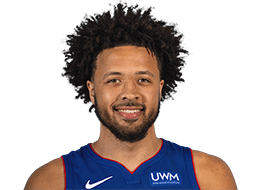
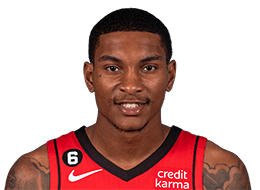
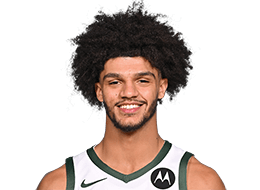
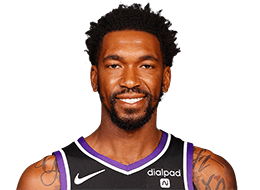
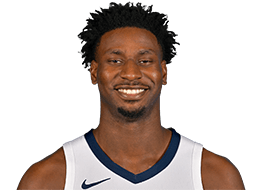
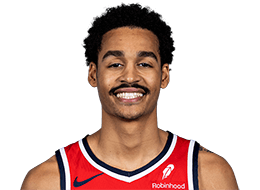
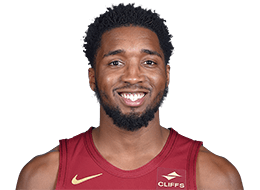
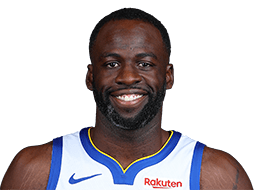
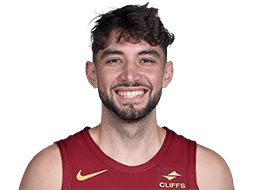
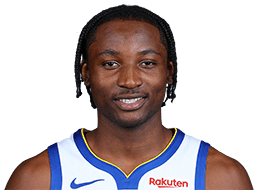

In [23]:
title = "Euro Fouls " + get_ss(int(season))
subtitle = ""
t = plot_table_rank(data_euroP,title=title,subtitle=subtitle,n=10)
t.save(fig_DIR + f"{league}_euro_foul_"+ season +".png",scale=3,web_driver="firefox")
t

## Estimate Frustration Fouls

In [24]:
FFoul_pID = []
for i in range(len(TO_Miss_pID)):
    if TO_Miss_pID[i] == Foul_pID[i]:
        FFoul_pID.append(Foul_pID[i])

In [25]:
data_frust = rank_data_pbp(
    FFoul_pID, player_dict, team_dict, sort="Player", var="Fouls"
)
data_frust.to_csv(export_DIR + "NBA_player_Frustration_fouls_"+ season +".csv", index=False)

GT(_tbl_data=   index      pID             Player  Fouls
0      1  1630595    Cade Cunningham      6
1      2  1629645   Kevin Porter Jr.      5
2      3  1641748  Andre Jackson Jr.      4
3      4  1628370         Malik Monk      4
4      5  1628991  Jaren Jackson Jr.      4
5      6  1629673       Jordan Poole      4
6      7  1628378   Donovan Mitchell      4
7      8   203110     Draymond Green      4
8      9  1629660          Ty Jerome      3
9     10  1630228   Jonathan Kuminga      3, _body=<great_tables._gt_data.Body object at 0x000002B616CCF3E0>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='Fouls', type=<ColInfoTypeEnum.default: 1>, column_label='Fouls', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B616AFA090>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Frustration Fouls 2024-25'), subtitle='', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B616D033B0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B616D02180>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_lef
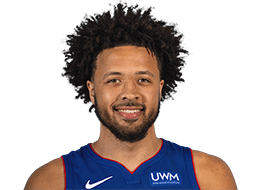
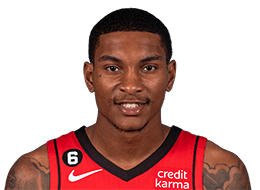
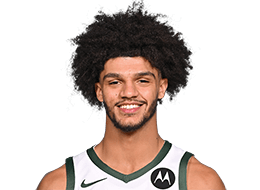
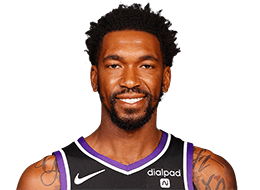
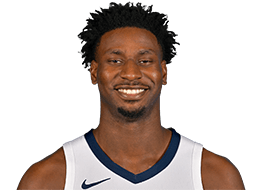
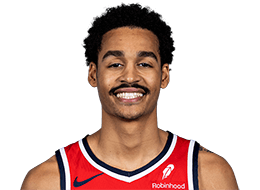
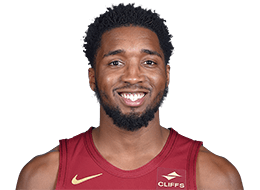
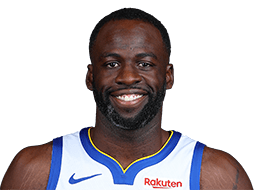
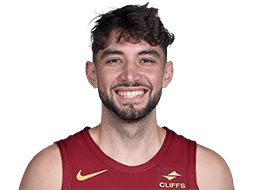
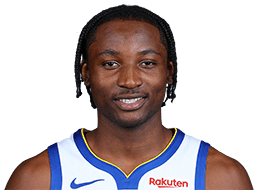

In [26]:
title = "Frustration Fouls " + get_ss(int(season))
subtitle = ""
t = plot_table_rank(data_frust,title=title,subtitle=subtitle,n=10)
t.save(fig_DIR + f"{league}_frust_foul_"+ season +".png",scale=3,web_driver="firefox")
t

# Coast to Coast Analysis

In basketball we say that whenever someone grabs a rebound, dribbles the ball up the court quickly and scores the basket, that the player is going coast to coast.
I came up with a method to estimate these events. I divide these events into two, coast-to-coast buckets i.e. when the player scores by themselves and coast-to-coast assists i.e when the player assists another player to score the ball.
For both types of events I have the same time cutoff of 5 seconds i.e. the player has to score/assist with 5 secs of grabbing the rebound.
Also for coast-to-coast buckets the FG has to bee within 5ft of the rim. NBA considers this distance as a rim attempt.

## Coast to Coast Assists

In [14]:
t = 5
Rebound_pID, Assist_pID = [], []
i, ii = 0, 0
for possession_event in tqdm(possession_events):
    if (
        (
            isinstance(possession_event, FieldGoal)
            and possession_event.is_made
            and possession_event.is_assisted
        )
        and (isinstance(possession_event.previous_event, Rebound))
        and possession_event.seconds_since_previous_event <= t
    ):
        if (
            possession_event.previous_event.player1_id
            == possession_event.player2_id
        ):
            if not possession_event.previous_event.oreb:
                Rebound_pID.append(possession_event.previous_event.player1_id)
                Assist_pID.append(possession_event.player2_id)

100%|██████████| 251917/251917 [00:00<00:00, 530338.38it/s]


GT(_tbl_data=   index      pID             Player  FGM
0      1     2544       LeBron James   22
1      2   203999       Nikola Jokic   19
2      3  1630595    Cade Cunningham   17
3      4  1629027         Trae Young   16
4      5   201566  Russell Westbrook   13
5      6  1627734   Domantas Sabonis   13
6      7   201939      Stephen Curry   13
7      8  1630567     Scottie Barnes   11
8      9  1630559      Austin Reaves   11
9     10  1630552      Jalen Johnson   11, _body=<great_tables._gt_data.Body object at 0x000002B61558A660>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='FGM', type=<ColInfoTypeEnum.default: 1>, column_label='FGM', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B616C43D70>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Coast to Coast Assists 2024-25'), subtitle='Player assists within 5s of grabbing rebound', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B616C8F080>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B616C8F680>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='
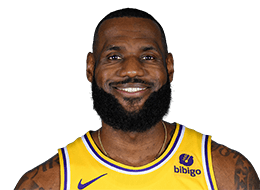
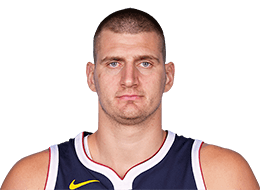
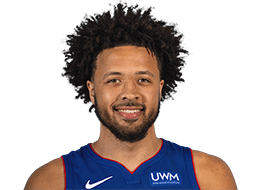
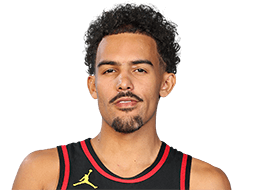
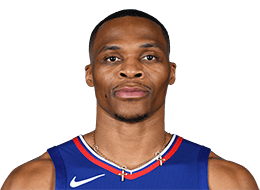
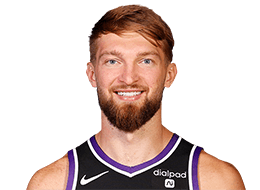
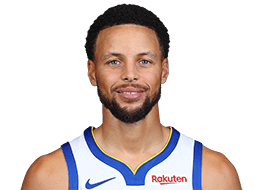
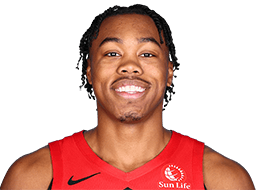
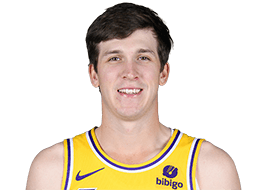
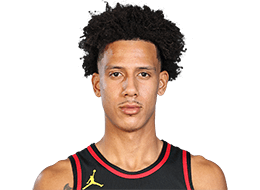

In [18]:
data = rank_data_pbp(Assist_pID, player_dict, team_dict, sort="Player", var="FGM")
title = "Coast to Coast Assists " + get_ss(int(season))
subtitle = "Player assists within 5s of grabbing rebound"
t = plot_table_rank(data,title=title,subtitle=subtitle,n=10)
t.save(fig_DIR + f"{league}_coast_assists_"+ season +".png",scale=3,web_driver="firefox")
t

## Coast to Coast Buckets

In [16]:
t = 5
dist = 5
Rebound_pID, FGM_pID = [], []
for possession_event in tqdm(possession_events):
    if (
        (
            isinstance(possession_event, FieldGoal)
            and possession_event.is_made
            and not possession_event.is_assisted
        )
        and (isinstance(possession_event.previous_event, Rebound))
        and possession_event.seconds_since_previous_event <= t
    ):
        if (
            not possession_event.previous_event.oreb
            and possession_event.distance <= dist
        ):
            if not possession_event.previous_event.oreb:
                Rebound_pID.append(possession_event.previous_event.player1_id)
                FGM_pID.append(possession_event.player1_id)

100%|██████████| 251917/251917 [00:00<00:00, 610193.81it/s]


In [ ]:
data_cb = rank_data_pbp(FGM_pID, player_dict, team_dict, sort="Player", var="FGM")

GT(_tbl_data=   index      pID                 Player  FGM
0      1   203507  Giannis Antetokounmpo   24
1      2  1630224            Jalen Green   14
2      3  1631101         Shaedon Sharpe   12
3      4  1629012          Collin Sexton   12
4      5  1630552          Jalen Johnson    9
5      6  1629632             Coby White    9
6      7  1630166            Deni Avdija    8
7      8  1641708          Amen Thompson    8
8      9  1628404              Josh Hart    8
9     10  1631097     Bennedict Mathurin    7, _body=<great_tables._gt_data.Body object at 0x000002B616BAEAE0>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='FGM', type=<ColInfoTypeEnum.default: 1>, column_label='FGM', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B614A4D070>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Coast to Coast Buckets 2024-25'), subtitle='Player scores <5ft within 5s of grabbing rebound', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B614ACBF20>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B615601A90>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo
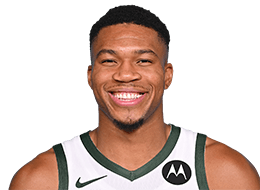
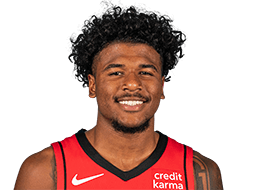
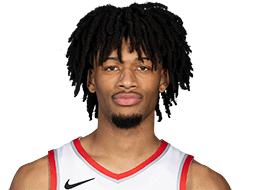
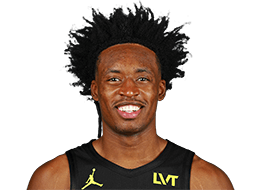
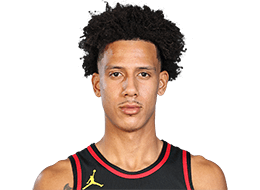
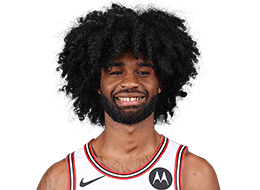
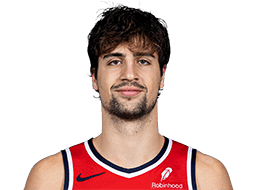
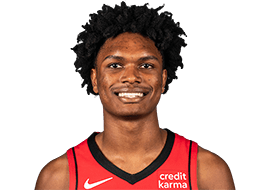
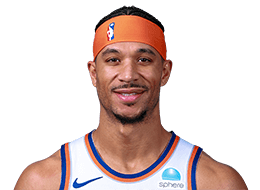
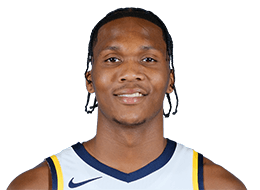

In [17]:
data = rank_data_pbp(FGM_pID, player_dict, team_dict, sort="Player", var="FGM")
title = "Coast to Coast Buckets " + get_ss(int(season))
subtitle = "Player scores <5ft within 5s of grabbing rebound"
t = plot_table_rank(data,title=title,subtitle=subtitle,n=10)
t.save(fig_DIR + f"{league}_coast_buckets_"+ season +".png",scale=3,web_driver="firefox")
t

# Assists after Offensive rebounds

In [ ]:
ast_time = 14
Rebound_pID, Assist_pID = [], []
for possession_event in tqdm(possession_events):
    if (
        isinstance(possession_event, FieldGoal)
        and possession_event.is_made
        and possession_event.is_assisted
    ) and (isinstance(possession_event.previous_event, Rebound)):
        if (
            possession_event.previous_event.player1_id
            == possession_event.player2_id
        ):
            if possession_event.previous_event.oreb:
                Rebound_pID.append(possession_event.previous_event.player1_id)
                Assist_pID.append(possession_event.player2_id)

In [ ]:
data_oa = rank_data_pbp(Assist_pID, player_dict, team_dict, sort="Player", var="AST")

In [ ]:
title = "Off Reb Assists " + year
footer = "Player assists after grabbing off rebound"
fig = plot_table_rank(data_oa, "AST", title=title, footer=footer, source="pbpstats")
fig.write_image(fig_DIR + f"{league}_oreb_assists_"+ season +".png", scale=3)

# Loose Ball Foul

In [ ]:
possa = []
Foul_pID = []
for possession_event in possession_events:
    if isinstance(possession_event, Foul):
        if possession_event.is_loose_ball_foul:
            possa.append(possession_event)
            Foul_pID.append(possession_event.player1_id)

In [ ]:
data_Foul = rank_data_pbp(
    Foul_pID, player_dict, team_dict, sort="Player", var="Fouls"
)
title = "Loose Ball Fouls " + "2023-24"
fig = plot_table_rank(data_Foul, "Fouls", sort="Player", title=title, source="pbpstats")
fig.write_image(fig_DIR + f"{league}_loose_foul_"+ season +".png", scale=3)

# Offensive Foul

In [ ]:
possa = []
Foul_pID = []
for possession_event in possession_events:
    if isinstance(possession_event, Foul):
        if possession_event.is_offensive_foul:
            possa.append(possession_event)
            Foul_pID.append(possession_event.player1_id)

In [ ]:
data_Foul = rank_data_pbp(
    Foul_pID, player_dict, team_dict, sort="Player", var="Fouls"
)
title = "Offensive Fouls " + "2023-24"
fig = plot_table_rank(data_Foul, "Fouls", sort="Player", title=title, source="pbpstats")
fig.write_image(fig_DIR + f"{league}_off_foul_"+ season +".png", scale=3)

# Chase Down Blocks

In [6]:
possessions = [game.possessions.items for game in games_list]
possession_events = list(chain(*[possession.events for possession in list(chain(*possessions))]))
t = 5
dist = 5
Block_pID, FGA_pID = [], []
for possession_event in possession_events:
    if (
        (
            isinstance(possession_event, FieldGoal)
            and not possession_event.is_made
        )
        and possession_event.is_blocked
        and possession_event.seconds_since_previous_event <= t
        and possession_event.distance <= dist
    ):
        if (
            isinstance(possession_event.previous_event, Rebound)
            and possession_event.previous_event.oreb
        ):
            pass
        else:
            Block_pID.append(possession_event.player3_id)
            FGA_pID.append(possession_event.player1_id)

GT(_tbl_data=   index      pID              Player  Block
0      1  1630596         Evan Mobley     10
1      2  1631114      Jalen Williams      9
2      3  1641705   Victor Wembanyama      8
3      4  1630595     Cade Cunningham      8
4      5   201572         Brook Lopez      8
5      6  1642258  Zaccharie Risacher      8
6      7  1630166         Deni Avdija      8
7      8  1630591         Jalen Suggs      7
8      9  1629675            Naz Reid      7
9     10  1628991   Jaren Jackson Jr.      7, _body=<great_tables._gt_data.Body object at 0x000002B614A14530>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='Block', type=<ColInfoTypeEnum.default: 1>, column_label='Block', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B614A2FB90>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Chase Down Blocks Leaders: 2024-25'), subtitle='Block <5 feet of rim and within 5s of poss change', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B6149F0EF0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B614A16060>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(s
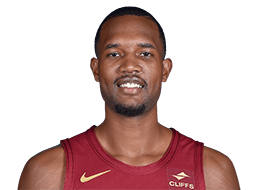
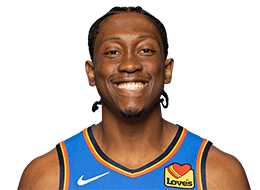
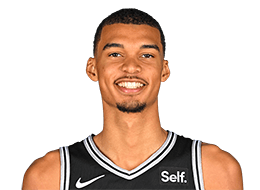
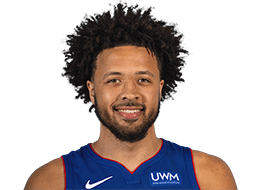
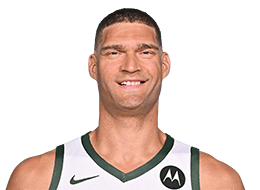
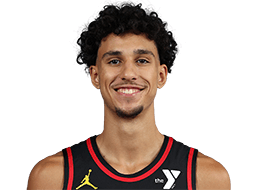
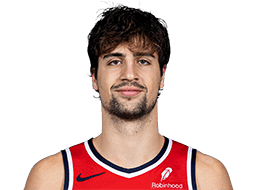
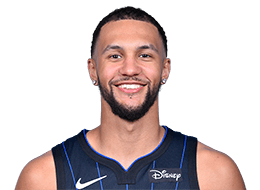
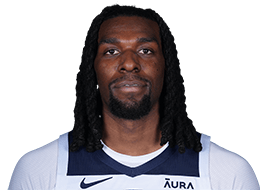
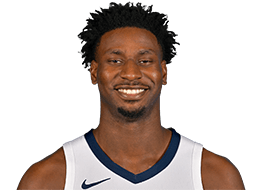

In [7]:
data = rank_data_pbp(Block_pID, player_dict, team_dict, sort="Player", var="Block")
title = "Chase Down Blocks Leaders: 2024-25"
subtitle = "Block <5 feet of rim and within 5s of poss change"
t = plot_table_rank(data,title=title,subtitle=subtitle,n=10)
t.save(fig_DIR + f"{league}_chasedown_"+ season +".png",scale=3,web_driver="firefox")
t

# Block and Score

In [8]:
possessions = [game.possessions.items for game in games_list]
possession_events = list(chain(*[possession.events for possession in list(chain(*possessions))]))
poss = []
Block_pID, FGA_pID = [], []
for possession_event in possession_events:
    if (
        (
            isinstance(possession_event, FieldGoal)
            and not possession_event.is_made
        )
        and possession_event.is_blocked
    ):  
        if (
            isinstance(possession_event.next_event.next_event, FieldGoal)
            and possession_event.next_event.next_event.is_made
        ): 
            # print(possession_event.player3_id)
            Block_pID.append(possession_event.player3_id)
            FGA_pID.append(possession_event.next_event.next_event.player1_id)
            poss.append(possession_event)
        else:
            pass

In [9]:
BScore_pID = []
BScore_poss = []
for i in range(len(Block_pID)):
    if Block_pID[i] == FGA_pID[i]:
        # print(Block_pID)
        BScore_pID.append(Block_pID[i])
        BScore_poss.append(poss[i])

GT(_tbl_data=   index      pID                 Player  BLK
0      1  1641705      Victor Wembanyama    8
1      2  1630596            Evan Mobley    5
2      3  1630591            Jalen Suggs    5
3      4  1631117         Walker Kessler    4
4      5   203497            Rudy Gobert    4
5      6  1630643               Jay Huff    3
6      7  1631106             Tari Eason    3
7      8  1628386          Jarrett Allen    3
8      9  1626171           Bobby Portis    3
9     10   203507  Giannis Antetokounmpo    3, _body=<great_tables._gt_data.Body object at 0x000002B614A95640>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='BLK', type=<ColInfoTypeEnum.default: 1>, column_label='BLK', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B614A2F560>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Block + Score Immediately'), subtitle='2024-25 Season, as of 2025-01-06', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B614AC9880>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B614AC96D0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category=
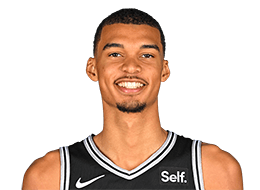
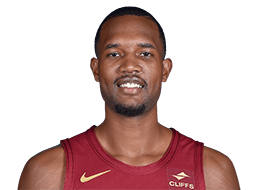
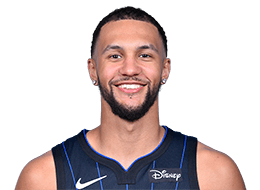
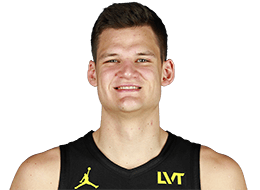
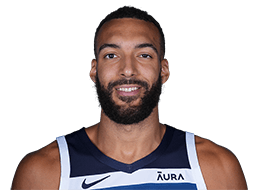
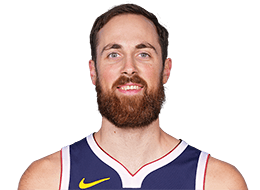
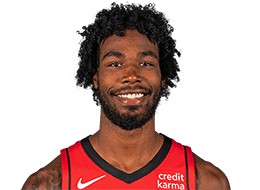
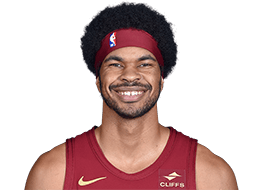
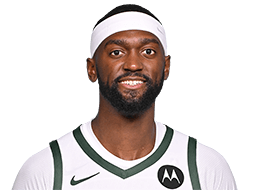
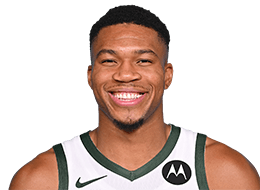

In [10]:
data = rank_data_pbp(BScore_pID, player_dict, team_dict, sort="Player", var="BLK")
title = "Block + Score Immediately" 
subtitle = get_ss(int(season)) + " Season, as of "+ datetime.today().strftime("%Y-%m-%d")
t = plot_table_rank(data,title=title,subtitle=subtitle,n=10)
t.save(fig_DIR + f"{league}_block_score_"+ season +".png",scale=3,web_driver="firefox")
t

# Steal and Score

In [11]:
possessions = [game.possessions.items for game in games_list]
possession_events = list(chain(*[possession.events for possession in list(chain(*possessions))]))
poss = []
Steal_pID, FGA_pID = [], []
for possession_event in possession_events:
    if (
        (
            isinstance(possession_event, Turnover)
        )
        and possession_event.is_steal
    ):  
        if (
            isinstance(possession_event.next_event, FieldGoal)
            and possession_event.next_event.is_made
            and not possession_event.next_event.is_assisted
        ): 
            # print(possession_event.player3_id)
            Steal_pID.append(possession_event.player3_id)
            FGA_pID.append(possession_event.next_event.player1_id)
            poss.append(possession_event)
        else:
            pass

In [12]:
SScore_pID = []
SScore_poss = []
for i in range(len(Steal_pID)):
    if Steal_pID[i] == FGA_pID[i]:
        # print(Steal_pID)
        SScore_pID.append(Steal_pID[i])
        SScore_poss.append(poss[i])

GT(_tbl_data=   index      pID                    Player  STL
0      1  1630700             Dyson Daniels   18
1      2  1631114            Jalen Williams   13
2      3  1631128           Christian Braun   12
3      4  1630532              Franz Wagner   12
4      5  1630178              Tyrese Maxey   11
5      6  1628368              De'Aaron Fox   10
6      7  1627739                 Kris Dunn   10
7      8   203484  Kentavious Caldwell-Pope   10
8      9  1628384                OG Anunoby   10
9     10  1630162           Anthony Edwards    9, _body=<great_tables._gt_data.Body object at 0x000002B614A95CA0>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='#', column_align='center', column_width=None), ColInfo(var='pID', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='STL', type=<ColInfoTypeEnum.default: 1>, column_label='STL', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002B614AAD7C0>, _spanners=Spanners([]), _heading=Heading(title=Md(text='Steal + Score Immediately'), subtitle='2024-25 Season, as of 2025-01-06', preheader=None), _stubhead=None, _source_notes=['bsky:@sradjoker.cc | x:@SravanNBA | source:pbpstats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002B614B24950>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002B614B246E0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='floralwhite'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Consolas']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value=10), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width
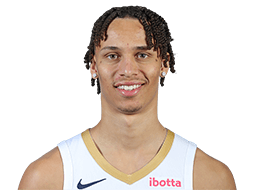
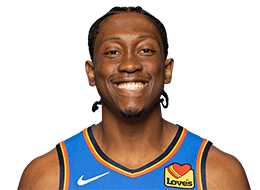
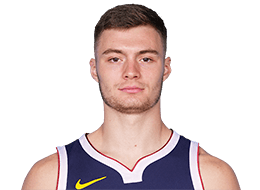
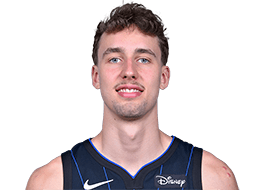
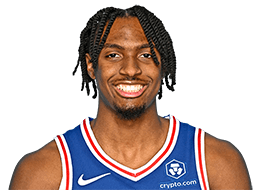
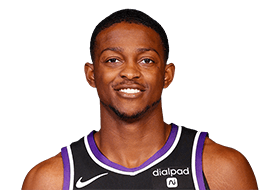
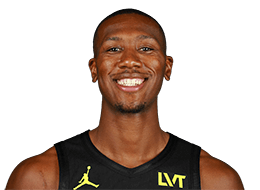
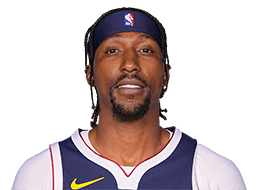
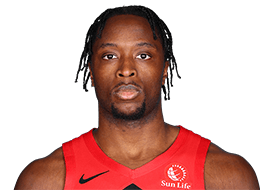
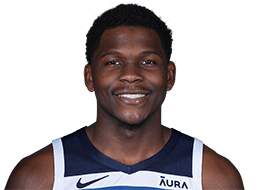

In [13]:
data = rank_data_pbp(SScore_pID, player_dict, team_dict, sort="Player", var="STL")
title = "Steal + Score Immediately" 
subtitle = get_ss(int(season)) + " Season, as of "+ datetime.today().strftime("%Y-%m-%d")
t = plot_table_rank(data,title=title,subtitle=subtitle,n=10)
# t.save(fig_DIR + f"{league}_steal_score_"+ season +".png",scale=3,web_driver="firefox")
t.save(fig_DIR + f"{league}_steal_score_ua_"+ season +".png",scale=3,web_driver="firefox")
t